# Linear regression models for predicting pollution

The [NO2 dataset](https://www.openml.org/d/547) contains 500 measurement of pollution caused by cars. The goal is to predict the concentration of $NO_2$ from data about traffic and atmospheric conditions. The predictive variables include the number of cars per hour, temperature, wind, and time of day.

In [6]:
# General imports
%matplotlib inline
from preamble import *
plt.rcParams['savefig.dpi'] = 100 # This controls the size of your figures
from matplotlib import cm
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
# Download NO2 data. Takes a while the first time.
no2 = oml.datasets.get_dataset(547)
X, y, _, _ = no2.get_data(target=no2.default_target_attribute); 
attribute_names = list(X)

## Quick visualization


In [3]:
df = pd.DataFrame(X, columns=attribute_names).join(pd.DataFrame(list(y),columns=['target']))
df.head()

,cars_per_hour,temperature_at_2m,wind_speed,temperature_diff_2m_25m,wind_direction,hour_of_day,day,target
0,7.69,9.2,4.8,-0.1,74.4,20,600,3.72
1,7.70,6.4,3.5,-0.3,56.0,14,196,3.10
2,4.81,-3.7,0.9,-0.1,281.3,4,513,3.31
3,6.95,-7.2,1.7,1.2,74.0,23,143,4.39
4,7.52,-1.3,2.6,-0.1,65.0,11,115,4.35


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   cars_per_hour            500 non-null    float64
 1   temperature_at_2m        500 non-null    float64
 2   wind_speed               500 non-null    float64
 3   temperature_diff_2m_25m  500 non-null    float64
 4   wind_direction           500 non-null    float64
 5   hour_of_day              500 non-null    uint8  
 6   day                      500 non-null    int64  
 7   target                   500 non-null    float64
dtypes: float64(6), int64(1), uint8(1)
memory usage: 28.0 KB


In [5]:
df.describe()

,cars_per_hour,temperature_at_2m,wind_speed,temperature_diff_2m_25m,wind_direction,hour_of_day,day,target
count,500.00,500.00,500.00,500.00,500.00,500.00,500.00,500.00
mean,6.97,0.85,3.06,0.15,143.37,12.38,310.47,3.70
std,1.09,6.52,1.78,1.07,86.51,6.80,200.98,0.75
min,4.13,-18.60,0.30,-5.40,2.00,1.00,32.00,1.22
25%,6.18,-3.90,1.68,-0.20,72.00,6.00,118.75,3.21
50%,7.43,1.10,2.80,0.00,97.00,12.50,212.00,3.85
75%,7.79,4.90,4.20,0.60,220.00,18.00,513.00,4.22
max,8.35,21.10,9.90,4.30,359.00,24.00,608.00,6.40


## Exercise 1: Model benchmark


### Exercise 1.1
Implement a function below which evaluates each classifier passed into it on the given data, and then returns both the train and test scores of each as a list. Use [`cross_validate`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html) function and standard Python built-ins. 

In [7]:
def evaluate_learners(models, X, y):
    """     
    Given a list of models [model1, model2, ..., modelN] return two lists:
     - a list with the scores obtained on the training samples for each model,
     - a list with the test scores obtained on the test samples for each model.
     The order of scores should match the order in which the models were originally provided. E.g.:     
     [Model1 train score, ..., ModelN train score], [Model1 test score, ..., ModelN test score]
    """
    xvals = [cross_validate(m, X, y, return_train_score= True, n_jobs=-1) for m in models]
    test_scores = [x['test_score'] for x in xvals]
    train_scores = [x['train_score'] for x in xvals]
    return train_scores, test_scores

### Exercise 1.2
Call the function you created with a Linear Regression, Ridge, Lasso and ElasticNet, as well as kNN.
Store the return values in the variables `train_scores` and `test_scores`. Then, run the code given below to produce a plot visualizing the scores.

In [8]:
models = [LinearRegression(), Ridge(), Lasso(), ElasticNet(), KNeighborsRegressor()]
models = np.array([m for m in models]).flatten()
train_scores, test_scores = evaluate_learners(models, X, y)

<AxesSubplot:>

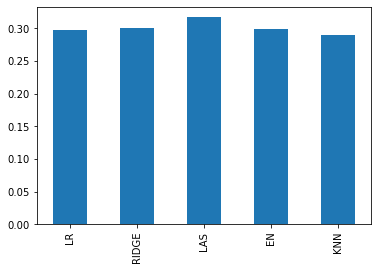

In [14]:
pd.DataFrame(train_scores, columns=["LR", "RIDGE", "LAS", "EN", "KNN"]).mean().plot(kind="bar")

<AxesSubplot:>

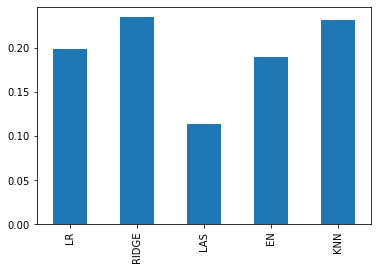

In [15]:
pd.DataFrame(test_scores, columns=["LR", "RIDGE", "LAS", "EN", "KNN"]).mean().plot(kind="bar")

## Exercise 2: Regularization 
We will now tune these algorithm's main regularization hyperparameter: the regularization hyperparameter (`alpha`) in Lasso and Ridge, and the number of neighbors (`n_neighbors`) in kNN.

We expect the optimum for the alpha parameters to lie in $[10^{-12},10^{12}]$ and for n_neighbors between 1 and 50. alpha should be varied on a log scale (i.e. [0.01, 0.1, 1, 10, 100]), k should be varied uniformly (i.e. [1,2,3,4]).

### Exercise 2.1
Vary the hyperparameters in the range given above and, for each regressor, create a line plot that plots both the training and test score for every value of the regularization hyperparameter. Hence, you should produce 3 plots, one for each regressor. Use the default 5-fold cross validation for all scores, but only plot the means.

Hints:
* Think about the time complexity of these models. Trying too many hyperparameter values may take too much time.
* You can make use of numpy's [logspace](https://docs.scipy.org/doc/numpy/reference/generated/numpy.logspace.html), [geomspace](https://docs.scipy.org/doc/numpy/reference/generated/numpy.geomspace.html?highlight=geomspace#numpy.geomspace), and [linspace](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linspace.html#numpy.linspace) functions.
* You can use matplotlib's default [plot](https://matplotlib.org/tutorials/introductory/pyplot.html) function to plot the train and test scores.
* You can manually loop over the hyperparameter ranges, or you can already check out scikit-learn's [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) function to save some programming. We'll see it again later in the course.

#### Solution

In [16]:
from sklearn.model_selection import GridSearchCV

param_a = {'alpha': np.logspace(-12, 12, num=22)}
param_elastic = {'l1_ratio': np.linspace(0, 1, num=11),
                 'alpha': np.logspace(-12, 12, num=25)}
param_k = {'kneighborsregressor__n_neighbors': np.geomspace(1, 60, num=12, dtype=int)[1:]}

models = [Ridge(), Lasso(), make_pipeline(StandardScaler(), KNeighborsRegressor()), ElasticNet()]

grids = [param_a,param_a,param_k,param_elastic]

In [17]:
# Generic plot for 1D grid search
def plot_tuning(grid_search, param_name, ax):
    """
    grid_search: the result of the GridSearchCV
    param_name: the name of the parameter that is being varied
    """
    ax.plot(grid_search.param_grid[param_name], grid_search.cv_results_['mean_test_score'], marker = '.', label = 'Test score')
    ax.plot(grid_search.param_grid[param_name], grid_search.cv_results_['mean_train_score'], marker = '.', label = 'Train score')
    ax.set_ylabel('score (ACC)')
    ax.set_xlabel(param_name)
    ax.legend(loc='lower left')
    ax.set_xscale('log')
    ax.set_title(grid_search.best_estimator_.__class__.__name__)
    bp, bs = grid_search.best_params_[param_name], grid_search.best_score_
    ax.text(bp,bs+0.01,"  best:{:.2E}, R2:{:.4f}".format(bp,bs))

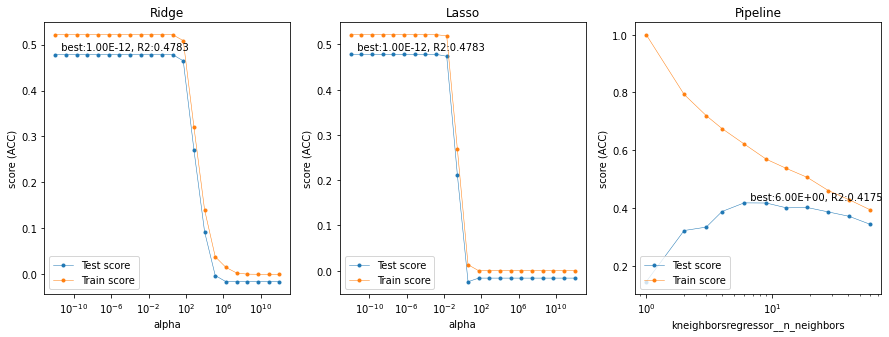

In [18]:
# Run the grid search
grid_searches = [GridSearchCV(m,grid,n_jobs=-1, cv=3, return_train_score=True).fit(X,y) for m,grid in zip(models,grids)]
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
for grid_search, param, ax in zip(grid_searches[0:3],['alpha','alpha','kneighborsregressor__n_neighbors'],axes):
    plot_tuning(grid_search, param, ax)

### Exercise 2.2
Interpret the plots. When are the methods underfitting? When are they overfitting? How sensitive are they to the regularization hyperparameter?

#### Solution

Ridge and Lasso behave very similarly, producing the same optimal result for small alpha's (small amounts of regularization), and then quickly dropping down to default performance (0 $R^2$) around alpha=0.1. Any more regularization makes the model completely underfit the data. The only difference is that Ridge has a slightly more gradual descent than Lasso. kNN yields a worse score (0.4175 $R^2$) even after tuning. It has a clear optimum around 9 nearest neighbors, after which it gradually starts underfitting.